# Power spectral density (PSD) of NEEM CFA data 
***
* Author: Yannick E. Heiser
* Email:  wfg813@alumni.ku.dk
* Last Update:   27th of March 2023
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iminuit import Minuit 
from ExternalFunctions import Chi2Regression
plt.rcParams['axes.labelsize'] = 40
plt.rcParams['font.size'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['legend.fontsize'] = 25
plt.rcParams['axes.axisbelow'] = True
import sys
import glob
import os
from tkinter import Tcl
from os.path import join
from scipy.ndimage import gaussian_filter1d
from scipy.signal import welch
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.ticker as ticker
!{sys.executable} -m pip install xlrd

### 1. Load CFA data

In [2]:
#NEEM_path = "/Users/yannickheiser/OneDrive - University of Copenhagen/Master Thesis/Data/NEEM/"
NEEM_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_NEEM/NEEM_CFA/" 
CFA_path = NEEM_path + "NEEM_CFA_1mm_2000-2050m.xls"

# Import the CFA data
CFA_data = pd.ExcelFile(CFA_path)
  
# View the sheet names
print(CFA_data.sheet_names)
  
# Load the excel_file's Sheet1 as a dataframe
CFA_df = CFA_data.parse('Sheet1')
CFA_df.head(5)

['Sheet1']


,Depth top (m),Cond (mikroS/cm),Na+ (ng/g),Ca++ (ng/g),Dust (#/mL) [SD>1.0],NH4+ (ng/g),NO3- (ng/g),H2O2 (ng/g),age (yr b2k)
0,2000.000,0.9572,49.3999,125.8613,35399.5219,3.1761,63.1084,NaN,70657.454545
1,2000.001,0.9280,47.9047,121.7237,35003.0868,3.0861,61.4177,NaN,70657.701818
2,2000.002,0.9014,46.4337,117.9628,33476.2933,3.0041,59.8933,NaN,70657.949091
3,2000.003,0.8614,44.1221,112.4952,29955.4606,2.8934,57.7212,NaN,70658.196364
4,2000.004,0.8292,42.0553,108.1816,28090.3967,2.8147,56.0782,NaN,70658.443636


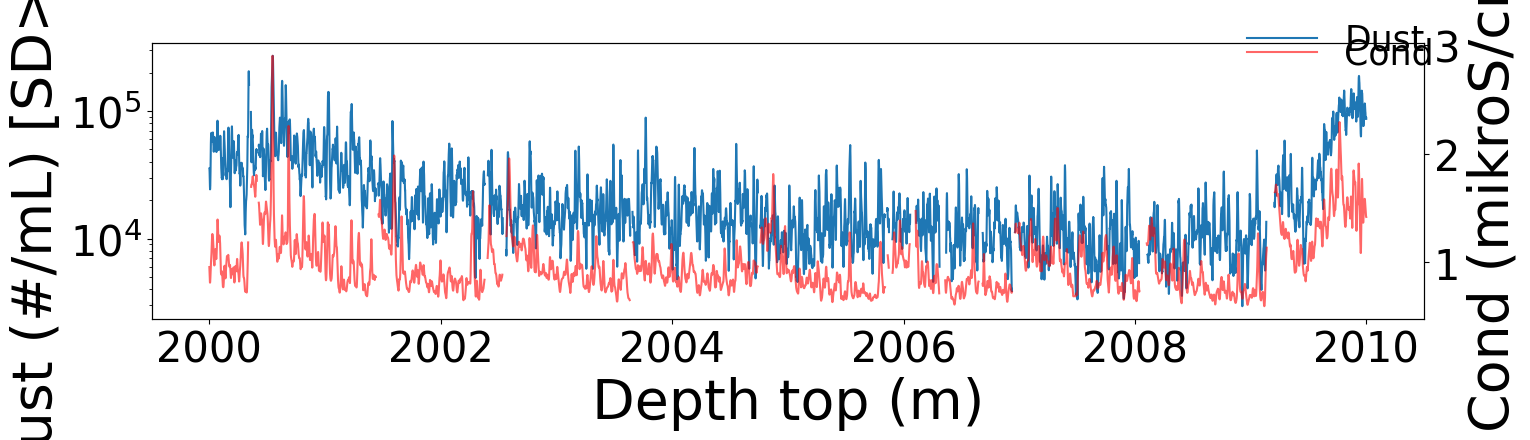

In [3]:
# First plot of Dust and Conductivity
fig, ax = plt.subplots(figsize=(16, 5))
ax2 = ax.twinx()
ax.semilogy(CFA_df["Depth top (m)"][:10000], CFA_df["Dust (#/mL) [SD>1.0]"][:10000], '-',label="Dust",alpha=1)
ax2.plot(CFA_df["Depth top (m)"][:10000], CFA_df["Cond (mikroS/cm)"][:10000], 'r-',label="Cond",alpha=0.6)
ax.set_xlabel('Depth top (m)')
ax.set_ylabel('Dust (#/mL) [SD>1.0]')
ax2.set_ylabel('Cond (mikroS/cm)')
ax.legend(loc='lower left', bbox_to_anchor= (0.85, 0.9), ncol=1,
            borderaxespad=0, frameon=False)
ax2.legend(loc='lower left', bbox_to_anchor= (0.85, 0.85), ncol=1,
            borderaxespad=0, frameon=False)
plt.tight_layout()
plt.show()

In [4]:
# Load d18O data
file_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_NEEM/NEEM_Isotopes/NEEM_FINAL_isotopes_5cm.xls"
df_d18O = pd.read_excel(file_path,skiprows=45,usecols="A,D,F,H",names=["Depth [m]","Age [ka b2k](AICC2012)","d18O","d18O_err (1 sigma)"])
df_d18O.head()

,Depth [m],Age [ka b2k](AICC2012),d18O,d18O_err (1 sigma)
0,1210.50,NaN,-31.230,0.05259
1,1210.55,NaN,-31.723,0.05259
2,1210.60,NaN,-33.963,0.05259
3,1210.65,NaN,-34.349,0.05259
4,1210.70,NaN,-33.315,0.05259


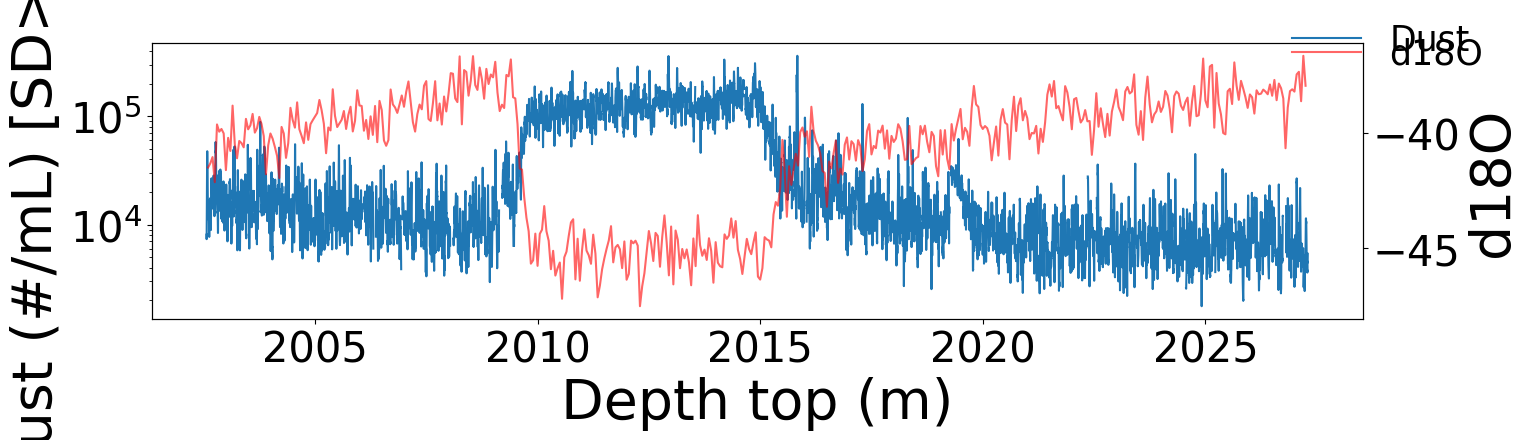

In [5]:
# Plot of Dust and d18O
CFA_df_slic = CFA_df[CFA_df["Depth top (m)"]<(3686)*0.55]
CFA_df_slic = CFA_df_slic[CFA_df_slic["Depth top (m)"]>(3642-1)*0.55]
df_d18O_slic = df_d18O[df_d18O["Depth [m]"]<CFA_df_slic["Depth top (m)"].iloc[-1]]
df_d18O_slic = df_d18O_slic[df_d18O_slic["Depth [m]"]>CFA_df_slic["Depth top (m)"].iloc[0]]

fig, ax = plt.subplots(figsize=(16, 5))
ax2 = ax.twinx()
ax.semilogy(CFA_df_slic["Depth top (m)"], CFA_df_slic["Dust (#/mL) [SD>1.0]"], '-',label="Dust",alpha=1)
ax2.plot(df_d18O_slic["Depth [m]"], df_d18O_slic["d18O"], 'r-',label="d18O",alpha=0.6)
ax.set_xlabel('Depth top (m)')
ax.set_ylabel('Dust (#/mL) [SD>1.0]')
ax2.set_ylabel('d18O')
ax.legend(loc='lower left', bbox_to_anchor= (0.93, 0.9), ncol=1,
            borderaxespad=0, frameon=False)
ax2.legend(loc='lower left', bbox_to_anchor= (0.93, 0.85), ncol=1,
            borderaxespad=0, frameon=False)
plt.tight_layout()
plt.show()

### 2. Interpolate missing data

In [6]:
# find missing data and see how large the gap is
for key in CFA_df_slic.keys()[1:-2]:
    print(key)
    missing = np.argwhere(np.isnan(np.array(CFA_df_slic[key]))).flatten()
    len_gaps_array = [] # List of the sizes in mm of different gaps 
    gap_size = 1
    for i in range(len(missing)-1):
        if missing[i+1]-missing[i]==1:
            gap_size += 1
        else:
            len_gaps_array.append(gap_size)
            gap_size = 1
    print("\t missing data: ", len(missing))
    print("\t % of missing data: ",len(missing)/len(CFA_df_slic[key])*100)
    print("\t max gap: ",np.max(np.array(len_gaps_array)))

Cond (mikroS/cm)
	 missing data:  1080
	 % of missing data:  4.363636363636364
	 max gap:  69
Na+ (ng/g)
	 missing data:  1393
	 % of missing data:  5.6282828282828286
	 max gap:  76
Ca++ (ng/g)
	 missing data:  1537
	 % of missing data:  6.21010101010101
	 max gap:  82
Dust (#/mL) [SD>1.0]
	 missing data:  994
	 % of missing data:  4.016161616161616
	 max gap:  72
NH4+ (ng/g)
	 missing data:  1408
	 % of missing data:  5.688888888888889
	 max gap:  116
NO3- (ng/g)
	 missing data:  1495
	 % of missing data:  6.040404040404041
	 max gap:  168


In [7]:
# Interpolation
CFA_interp = CFA_df.copy()
for key in CFA_df.keys()[1:-2]:
    print(key)
    missing = np.argwhere(np.isnan(np.array(CFA_df[key]))).flatten()
    y_noNaNs = np.delete(np.array(CFA_df[key]),missing)    # Delete missing values
    depth_noNaNs = np.delete(np.array(CFA_df["Depth top (m)"]),missing)
    #cs = CubicSpline(depth_noNaNs, y_noNaNs)
    cs = PchipInterpolator(depth_noNaNs, y_noNaNs)
    y_new = cs(CFA_df["Depth top (m)"])
    CFA_interp[key] = y_new

Cond (mikroS/cm)
Na+ (ng/g)
Ca++ (ng/g)
Dust (#/mL) [SD>1.0]
NH4+ (ng/g)
NO3- (ng/g)


In [8]:
# check new interpolated data
CFA_interp_slic = CFA_interp[CFA_interp["Depth top (m)"]<(3686)*0.55]
CFA_interp_slic = CFA_interp_slic[CFA_interp_slic["Depth top (m)"]>(3642-1)*0.55]

for key in CFA_interp_slic.keys()[1:-2]:
    print(key)
    missing = np.argwhere(np.isnan(np.array(CFA_interp_slic[key]))).flatten()
    len_gaps_array = [] # List of the sizes in mm of different gaps 
    gap_size = 1
    for i in range(len(missing)-1):
        if missing[i+1]-missing[i]==1:
            gap_size += 1
        else:
            len_gaps_array.append(gap_size)
            gap_size = 1
    print("\t missing data: ", len(missing))
    print("\t % of missing data: ",len(missing)/len(CFA_interp_slic[key])*100)
CFA_interp_slic.head()

Cond (mikroS/cm)
	 missing data:  0
	 % of missing data:  0.0
Na+ (ng/g)
	 missing data:  0
	 % of missing data:  0.0
Ca++ (ng/g)
	 missing data:  0
	 % of missing data:  0.0
Dust (#/mL) [SD>1.0]
	 missing data:  0
	 % of missing data:  0.0
NH4+ (ng/g)
	 missing data:  0
	 % of missing data:  0.0
NO3- (ng/g)
	 missing data:  0
	 % of missing data:  0.0


,Depth top (m),Cond (mikroS/cm),Na+ (ng/g),Ca++ (ng/g),Dust (#/mL) [SD>1.0],NH4+ (ng/g),NO3- (ng/g),H2O2 (ng/g),age (yr b2k)
2551,2002.551,1.044638,35.386801,55.215085,12756.954682,1.126816,64.802555,NaN,71186.178182
2552,2002.552,1.053359,34.908770,55.349388,12533.003895,1.146882,64.671126,NaN,71186.356364
2553,2002.553,1.062309,34.420666,55.475033,12295.928952,1.166981,64.537724,NaN,71186.534545
2554,2002.554,1.071514,33.925007,55.593180,12045.890426,1.187068,64.403140,NaN,71186.712727
2555,2002.555,1.081003,33.424313,55.704991,11783.048888,1.207099,64.268160,NaN,71186.890909


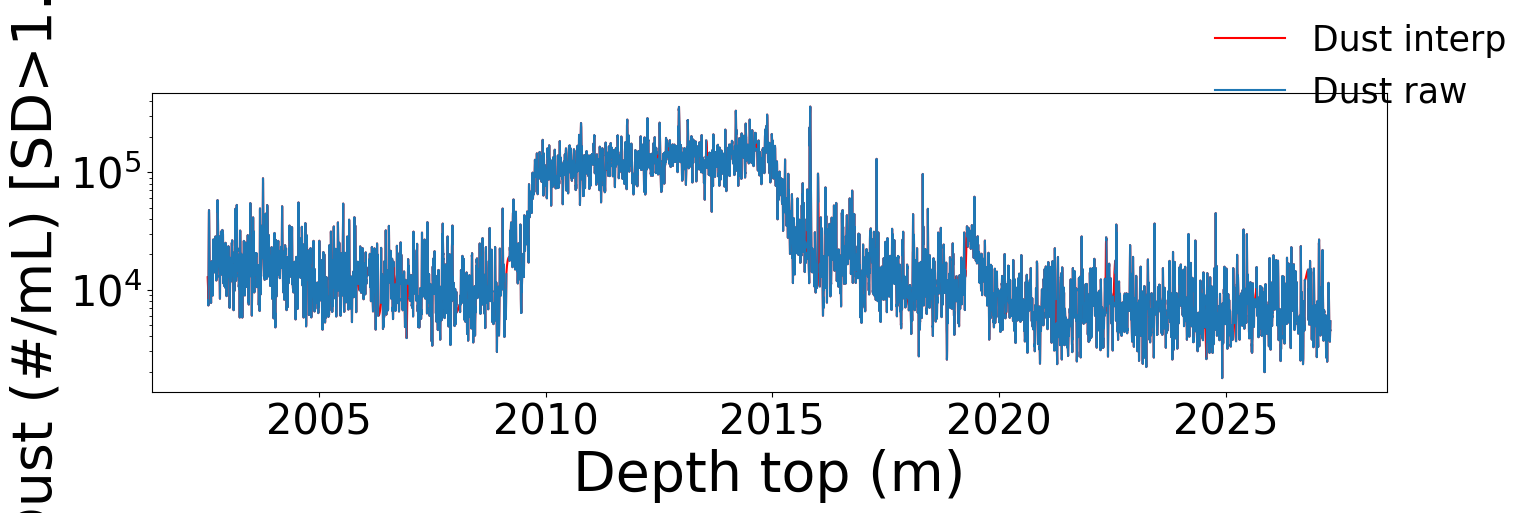

In [9]:
# Plot interpolated and original data
fig, ax = plt.subplots(figsize=(16, 5))
ax.semilogy(CFA_interp_slic["Depth top (m)"], CFA_interp_slic["Dust (#/mL) [SD>1.0]"], 'r-',label="Dust interp",alpha=1)
ax.semilogy(CFA_df_slic["Depth top (m)"], CFA_df_slic["Dust (#/mL) [SD>1.0]"], '-',label="Dust raw",alpha=1)
ax.set_xlabel('Depth top (m)')
ax.set_ylabel('Dust (#/mL) [SD>1.0]')
ax.legend(loc="best", bbox_to_anchor= (0.85, 0.9), ncol=1,
            borderaxespad=0, frameon=False)

plt.tight_layout()
plt.show()

In [10]:
# Save interpolated data as csv
#CFA_interp_slic.to_csv("/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/CFA_interpolated/CFA_interpolated.csv",index=False)

In [11]:
# Import xLASM
def read_csv(path):
    """
    read in csv files with grain size data and put it in dict of dataframes
    --------------------------------------
    param: (str) path: path of csv files
    """
    df = {}
    if path != None:
        os.chdir(path)    
    files = glob.glob("*.csv")
    files = Tcl().call('lsort', '-dict', files) #sort csv files after name
    for i in range(len(files)):
        file = files[i]
        bag = file[:-4]
        df[bag] = pd.read_csv(file)
    os.chdir("/home/jovyan/work/Master Thesis")
    return df

file_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/grain_sizes_depth/10mm_intervall"
df_sizes = read_csv(file_path)
df_sizes["nmx3676c"].head(5)

,crop_image,depth[m],equivalent_diameter[px],grain_size[px],grain_size_err[px]
0,0,2021.2505,244.304540,1.937896e+06,0
1,0,2021.2515,276.217056,2.369657e+06,0
2,0,2021.2525,273.532315,2.304709e+06,0
3,0,2021.2535,285.619165,2.446542e+06,0
4,0,2021.2545,273.701733,2.242376e+06,0


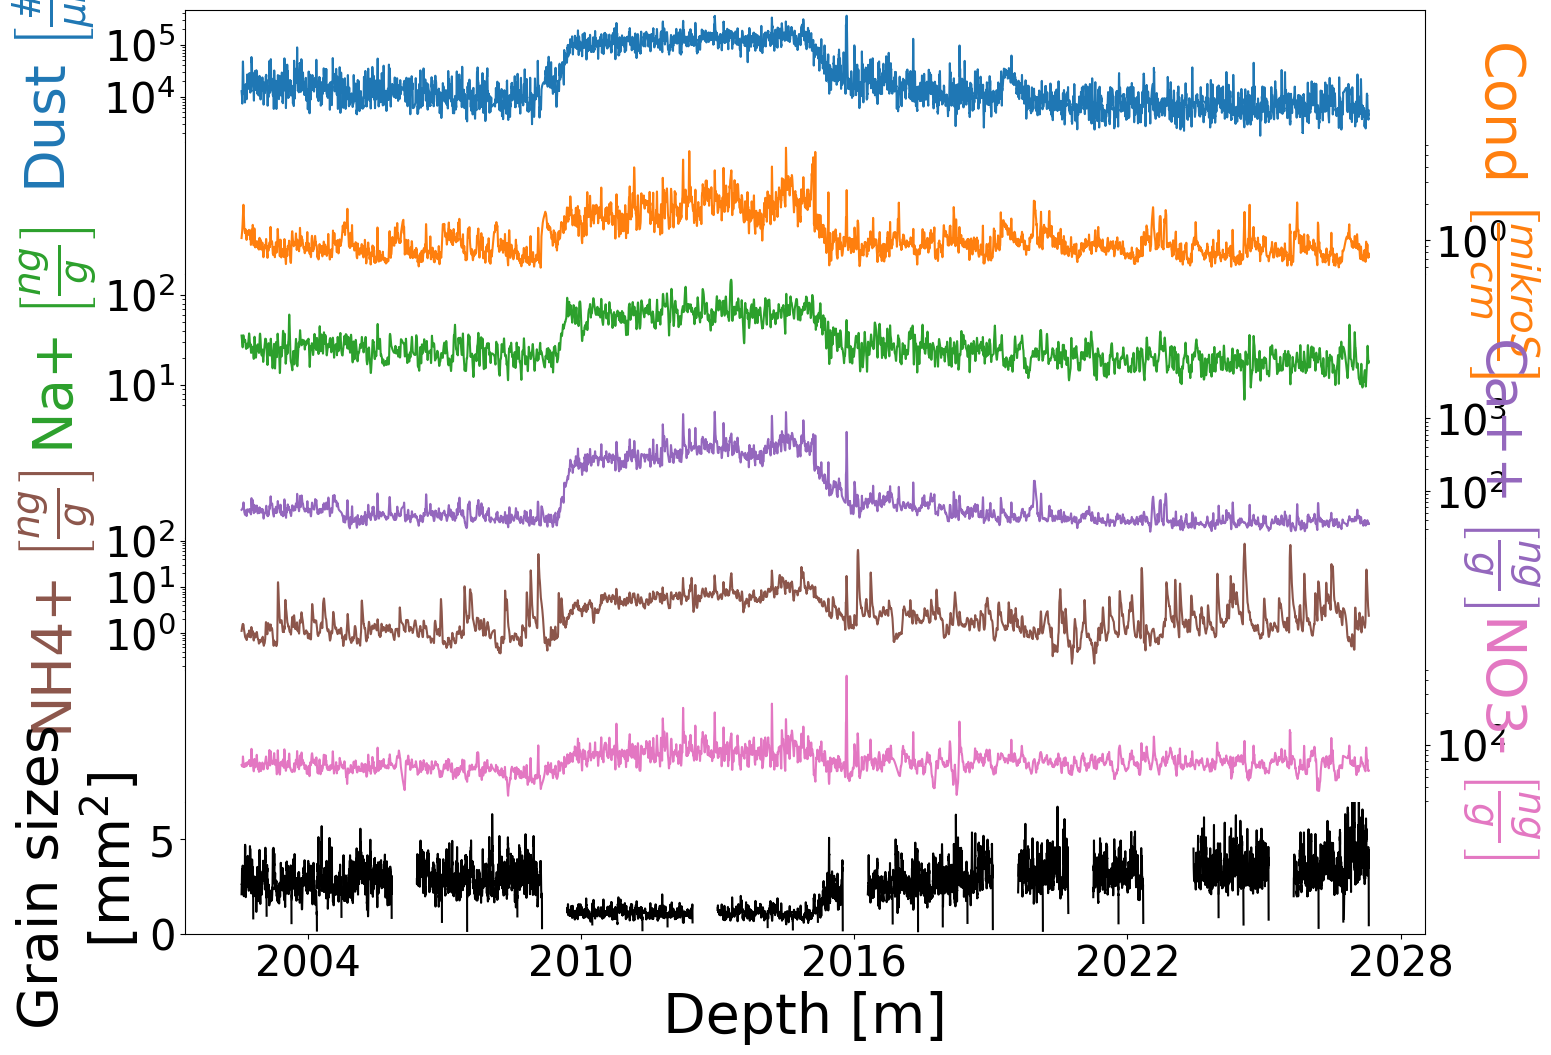

In [12]:
# Plot of all together


fig, ax = plt.subplots(7,1,figsize=(16, 12),sharex=True)

# Plot data
for bag in df_sizes.keys():
    ax[-1].plot(df_sizes[bag]["depth[m]"],df_sizes[bag]["grain_size[px]"]/1000000, '-',color="black",label="Grain size",alpha=1)
ax[0].semilogy(CFA_interp_slic["Depth top (m)"], CFA_interp_slic["Dust (#/mL) [SD>1.0]"], '-',color="tab:blue",label="Dust",alpha=1)
ax[1].semilogy(CFA_interp_slic["Depth top (m)"], CFA_interp_slic["Cond (mikroS/cm)"], '-',color="tab:orange",label="Cond",alpha=1)
ax[2].semilogy(CFA_interp_slic["Depth top (m)"], CFA_interp_slic["Na+ (ng/g)"], '-',color="tab:green",label="Na+",alpha=1)
ax[3].semilogy(CFA_interp_slic["Depth top (m)"], CFA_interp_slic["Ca++ (ng/g)"], '-',color="tab:purple",label="Ca++",alpha=1)
ax[4].semilogy(CFA_interp_slic["Depth top (m)"], CFA_interp_slic["NH4+ (ng/g)"], '-',color="tab:brown",label="NH4+",alpha=1)
ax[5].semilogy(CFA_interp_slic["Depth top (m)"], CFA_interp_slic["NO3- (ng/g)"], '-',color="tab:pink",label="NO3-",alpha=1)

# Set axis labels
ax[-1].set_xlabel('Depth [m]')
ax[0].set_ylabel(r'Dust $\left[\frac{\#}{µL}\right]$',color="tab:blue")
ax[1].set_ylabel(r'Cond $\left[\frac{mikroS}{cm}\right]$',rotation=270,labelpad=25,color="tab:orange")
ax[2].set_ylabel(r'Na+ $\left[\frac{ng}{g}\right]$',color="tab:green")
ax[3].set_ylabel(r'Ca++ $\left[\frac{ng}{g}\right]$',rotation=270,labelpad=25,color="tab:purple")
ax[4].set_ylabel(r'NH4+ $\left[\frac{ng}{g}\right]$',color="tab:brown")
ax[5].set_ylabel(r'NO3- $\left[\frac{ng}{g}\right]$',rotation=270,labelpad=25,color="tab:pink")
ax[-1].set_ylabel('Grain sizes \n [mm$^2$]',color="black")
#ax[0].set_title("CFA vs. grain sizes (NGRIP)")

# Remove top and bottom spines from the axes
ax[1].spines['top'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[3].spines['top'].set_visible(False)
ax[4].spines['top'].set_visible(False)
ax[5].spines['top'].set_visible(False)
ax[-1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[3].spines['bottom'].set_visible(False)
ax[4].spines['bottom'].set_visible(False)
ax[5].spines['bottom'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)


# Ticks and Labels on right side and remove x ticks
ax[1].yaxis.tick_right()
ax[3].yaxis.tick_right()
ax[5].yaxis.tick_right()
ax[0].tick_params("x",bottom=False)
ax[1].tick_params("x",bottom=False)
ax[2].tick_params("x",bottom=False)
ax[3].tick_params("x",bottom=False)
ax[4].tick_params("x",bottom=False)
ax[5].tick_params("x",bottom=False)
ax[-1].ticklabel_format(useOffset=False)    # No offset for x-axis labels
ax[1].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")
ax[5].yaxis.set_label_position("right")
ax[-1].xaxis.set_major_locator(plt.MaxNLocator(5))    # max 5 ticks on x-axis

ax[-1].set_ylim(ymin=0,ymax=7)


#ax[0].ticklabel_format(axis="y",style="sci",scilimits=(0,0))

fig.subplots_adjust(hspace=0)
#fig.savefig("Plots/17_CFA_xLASM_overview.png",dpi=100)
fig.show()

### 3. Create PSD and perform linear fits

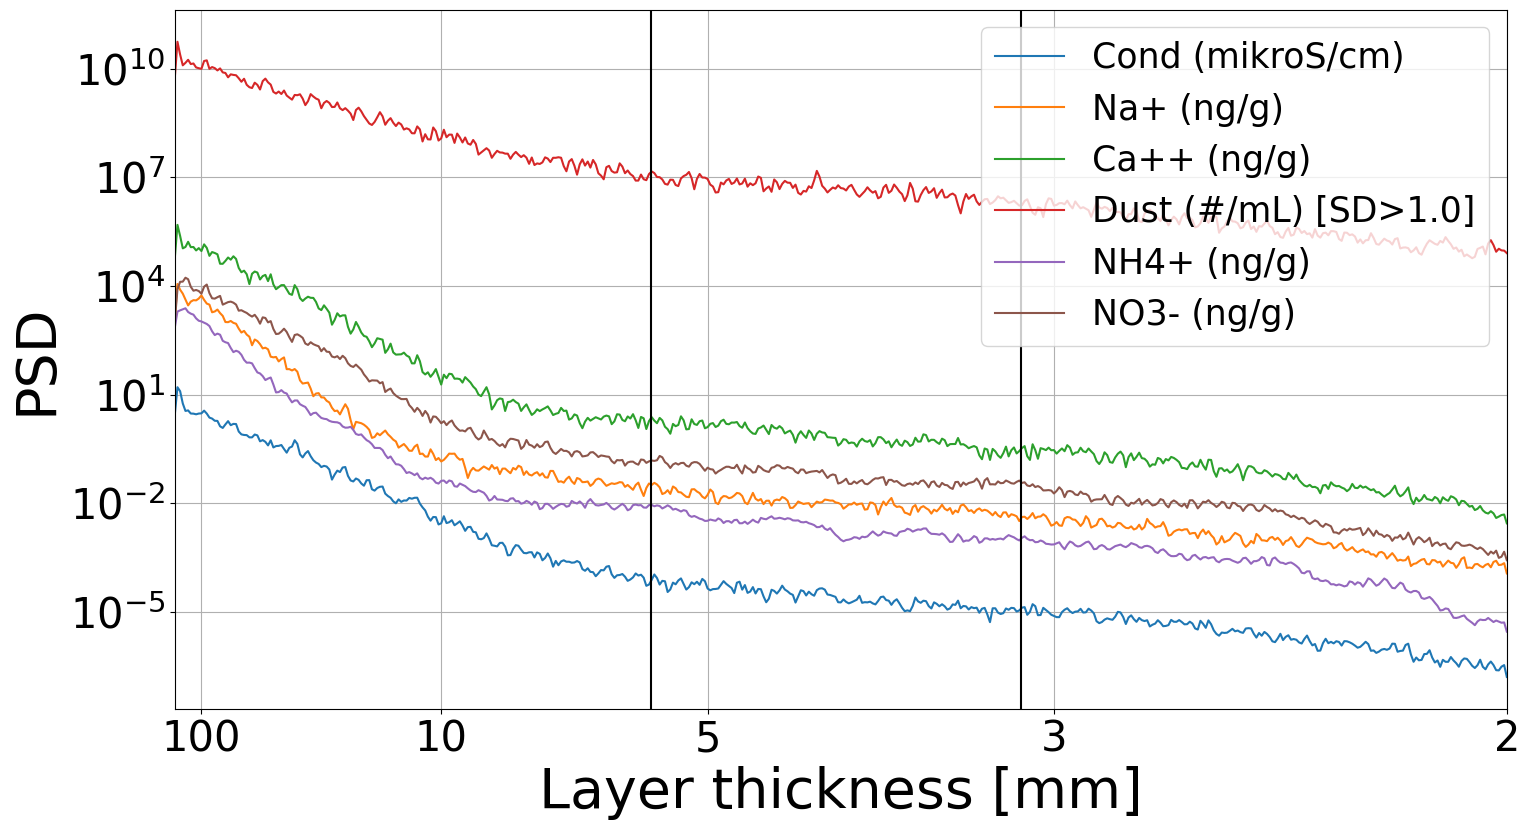

In [13]:
# Plot PSD
fs = 1 # sampling frequency in [1/mm]
fig, ax = plt.subplots(figsize=(16, 9))
for key in CFA_interp_slic.keys()[1:-2]:
    f, Pxx = welch(CFA_interp_slic[key],fs,nperseg = 1000)
    ax.semilogy(f, Pxx,label=key)
ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
ax.vlines(1/3.15,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],color="black")
ax.vlines(1/5.6,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],color="black")
ax.set_xlim(0.0001,0.5)
ax.set_xticks([1/100,0.1,0.2,0.33,0.5])
ax.set_xticklabels([100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
ax.set_xlabel('Layer thickness [mm]')
ax.set_ylabel('PSD')
ax.legend(loc="upper right")
ax.grid()
fig.tight_layout()
fig.savefig("Plots/17_CFA_PSD.png",dpi=100)
fig.show()

In [14]:
# Create dict containing desired resolutions in mm
resolution_mm = {}

sampling resolution (Cond (mikroS/cm)):  7.31  +  0.72 mm
	 fit signal interval:  0.0 < f <  0.14 1/mm
	 fit signal interval:  0.2 < f <  0.33 1/mm


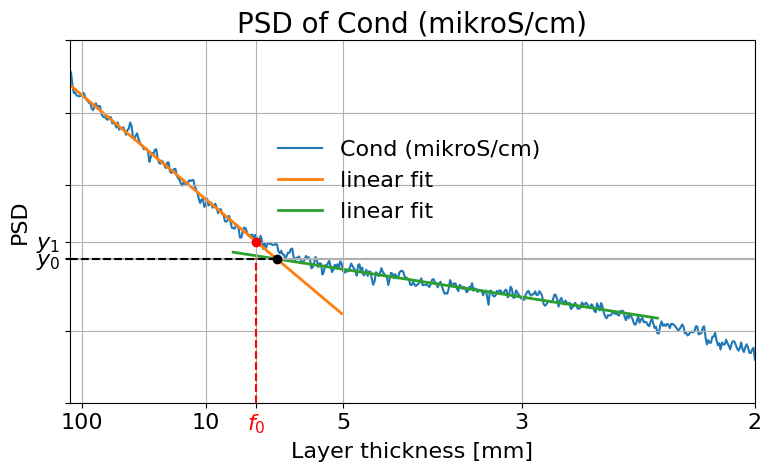

In [15]:
# Plot PSD of Conductivity
fs = 1 # sampling frequency in [1/mm]
for key in CFA_interp_slic.keys()[1:2]:
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.ticklabel_format(axis='y', style='sci', useOffset=False)    
    ax.grid()
    f, Pxx = welch(CFA_interp_slic[key],fs,nperseg = 1000)
    a1,b1=np.polyfit(f[:143],np.log(Pxx[:143]),1)
    a2,b2=np.polyfit(f[200:334],np.log(Pxx[200:334]),1)
    intersection_f = (b1-b2)/(a2-a1)
    intersection_y = a1*intersection_f+b1
    ax.semilogy(f, Pxx,label=key,zorder=0)
    ax.plot(f[:200],np.exp(a1*f[:200]+b1),label="linear fit",zorder=0,lw=2)
    ax.plot(f[120:430],np.exp(a2*f[120:430]+b2),label="linear fit",zorder=0,lw=2)
    ax.scatter(intersection_f,np.exp(intersection_y),c="black",alpha=1,marker="o",zorder=1)
    ax.axhline(y=np.exp(intersection_y), xmin=0, xmax=intersection_f/0.5,ls="--",c="black")
    y2 = 3*np.exp(intersection_y)
    f_final = (np.log(y2)-b1)/a1
    ax.scatter(f_final,y2,c="red",alpha=1,marker="o")
    ax.axvline(x=f_final, ymax=0.4,ls="--",c="red")
    f_err_mm = abs(1/f_final-1/intersection_f)
    print("sampling resolution ({}): ".format(key),round(1/f_final,2)," + ",round(f_err_mm,2),"mm")
    print("\t fit signal interval: ",round(f[0],2),"< f < ", round(f[143],2),"1/mm")
    print("\t fit signal interval: ",round(f[200],2),"< f < ", round(f[334],2),"1/mm")
    resolution_mm[key] = round(1/f_final,2)
    ax.set_xlim(0.001,0.5)
    ax.set_xticks([f_final,1/100,0.1,0.2,0.33,0.5])
    ax.set_xticklabels([r"$f_{0}$",100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()[1:-1]
    yticks = np.concatenate((yticks,np.array([np.exp(intersection_y),y2])))
    ax.set_yticks(yticks)
    y_labels = np.ones(len(yticks[:-2]),dtype="U8")
    y_labels[:] = ""
    ylabels = np.concatenate((y_labels,np.array(["$y_0$","$y_1$"])))
    y_color = np.ones(len(yticks[:-2]),dtype="U8")
    y_color[:] = "black"
    y_color = np.concatenate((y_color,np.array(["black","black"])))
    ax.set_yticklabels(ylabels)
    x_color = np.ones(len(xticks[:-1]),dtype="U8")
    x_color[:] = "black"
    x_color = np.concatenate((np.array(["red"]),x_color))
    [t.set_color(i) for (i,t) in zip(y_color,ax.yaxis.get_ticklabels())]
    [t.set_color(i) for (i,t) in zip(x_color,ax.xaxis.get_ticklabels())]
    ax.set_xlabel('Layer thickness [mm]')
    ax.set_ylabel('PSD')
    ax.set_title("PSD of {}".format(key))
    ax.legend(bbox_to_anchor= (0.7, 0.75), ncol=1,
                borderaxespad=0, frameon=False)
    fig.tight_layout()
    fig.show()

sampling resolution (Na+ (ng/g)):  12.12  +  1.14 mm
	 fit signal interval:  0.0 < f <  0.08 1/mm
	 fit signal interval:  0.11 < f <  0.43 1/mm


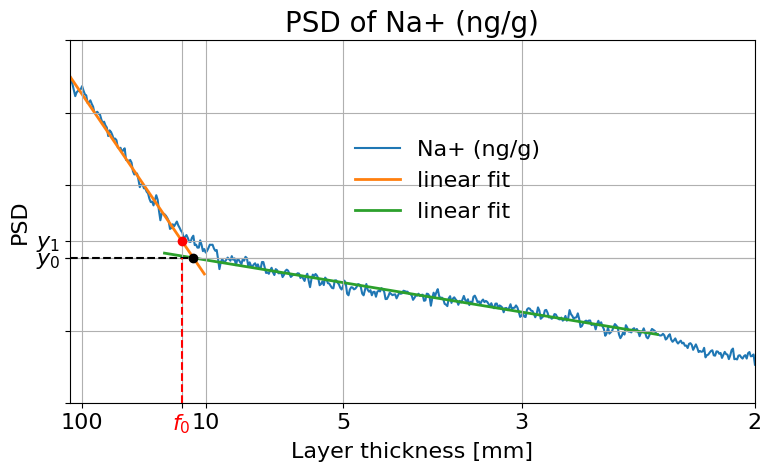

In [16]:
# Plot PSD of Na+
fs = 1 # sampling frequency in [1/mm]
for key in CFA_interp_slic.keys()[2:3]:
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.ticklabel_format(axis='y', style='sci', useOffset=False)    
    ax.grid()
    f, Pxx = welch(CFA_interp_slic[key],fs,nperseg = 1000)
    a1,b1=np.polyfit(f[:70],np.log(Pxx[:70]),1)
    a2,b2=np.polyfit(f[110:430],np.log(Pxx[110:430]),1)
    intersection_f = (b1-b2)/(a2-a1)
    intersection_y = a1*intersection_f+b1
    ax.semilogy(f, Pxx,label=key,zorder=0)
    ax.plot(f[:100],np.exp(a1*f[:100]+b1),label="linear fit",zorder=0,lw=2)
    ax.plot(f[70:430],np.exp(a2*f[70:430]+b2),label="linear fit",zorder=0,lw=2)
    ax.scatter(intersection_f,np.exp(intersection_y),c="black",alpha=1,marker="o",zorder=1)
    ax.axhline(y=np.exp(intersection_y), xmin=0, xmax=intersection_f/0.5,ls="--",c="black")
    y2 = 3*np.exp(intersection_y)
    f_final = (np.log(y2)-b1)/a1
    ax.scatter(f_final,y2,c="red",alpha=1,marker="o")
    ax.axvline(x=f_final, ymax=0.4,ls="--",c="red")
    f_err_mm = abs(1/f_final-1/intersection_f)
    print("sampling resolution ({}): ".format(key),round(1/f_final,2)," + ",round(f_err_mm,2),"mm")
    print("\t fit signal interval: ",round(f[0],2),"< f < ", round(f[80],2),"1/mm")
    print("\t fit signal interval: ",round(f[110],2),"< f < ", round(f[430],2),"1/mm")
    resolution_mm[key] = round(1/f_final,2)
    ax.set_xlim(0.001,0.5)
    ax.set_xticks([f_final,1/100,0.1,0.2,0.33,0.5])
    ax.set_xticklabels([r"$f_{0}$",100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()[1:-1]
    yticks = np.concatenate((yticks,np.array([np.exp(intersection_y),y2])))
    ax.set_yticks(yticks)
    y_labels = np.ones(len(yticks[:-2]),dtype="U8")
    y_labels[:] = ""
    ylabels = np.concatenate((y_labels,np.array(["$y_0$","$y_1$"])))
    y_color = np.ones(len(yticks[:-2]),dtype="U8")
    y_color[:] = "black"
    y_color = np.concatenate((y_color,np.array(["black","black"])))
    ax.set_yticklabels(ylabels)
    x_color = np.ones(len(xticks[:-1]),dtype="U8")
    x_color[:] = "black"
    x_color = np.concatenate((np.array(["red"]),x_color))
    [t.set_color(i) for (i,t) in zip(y_color,ax.yaxis.get_ticklabels())]
    [t.set_color(i) for (i,t) in zip(x_color,ax.xaxis.get_ticklabels())]
    ax.set_xlabel('Layer thickness [mm]')
    ax.set_ylabel('PSD')
    ax.set_title("PSD of {}".format(key))
    ax.legend(bbox_to_anchor= (0.7, 0.75), ncol=1,
                borderaxespad=0, frameon=False)
    fig.tight_layout()
    fig.show()

sampling resolution (Ca++ (ng/g)):  8.8  +  0.87 mm
	 fit signal interval:  0.0 < f <  0.12 1/mm
	 fit signal interval:  0.12 < f <  0.42 1/mm


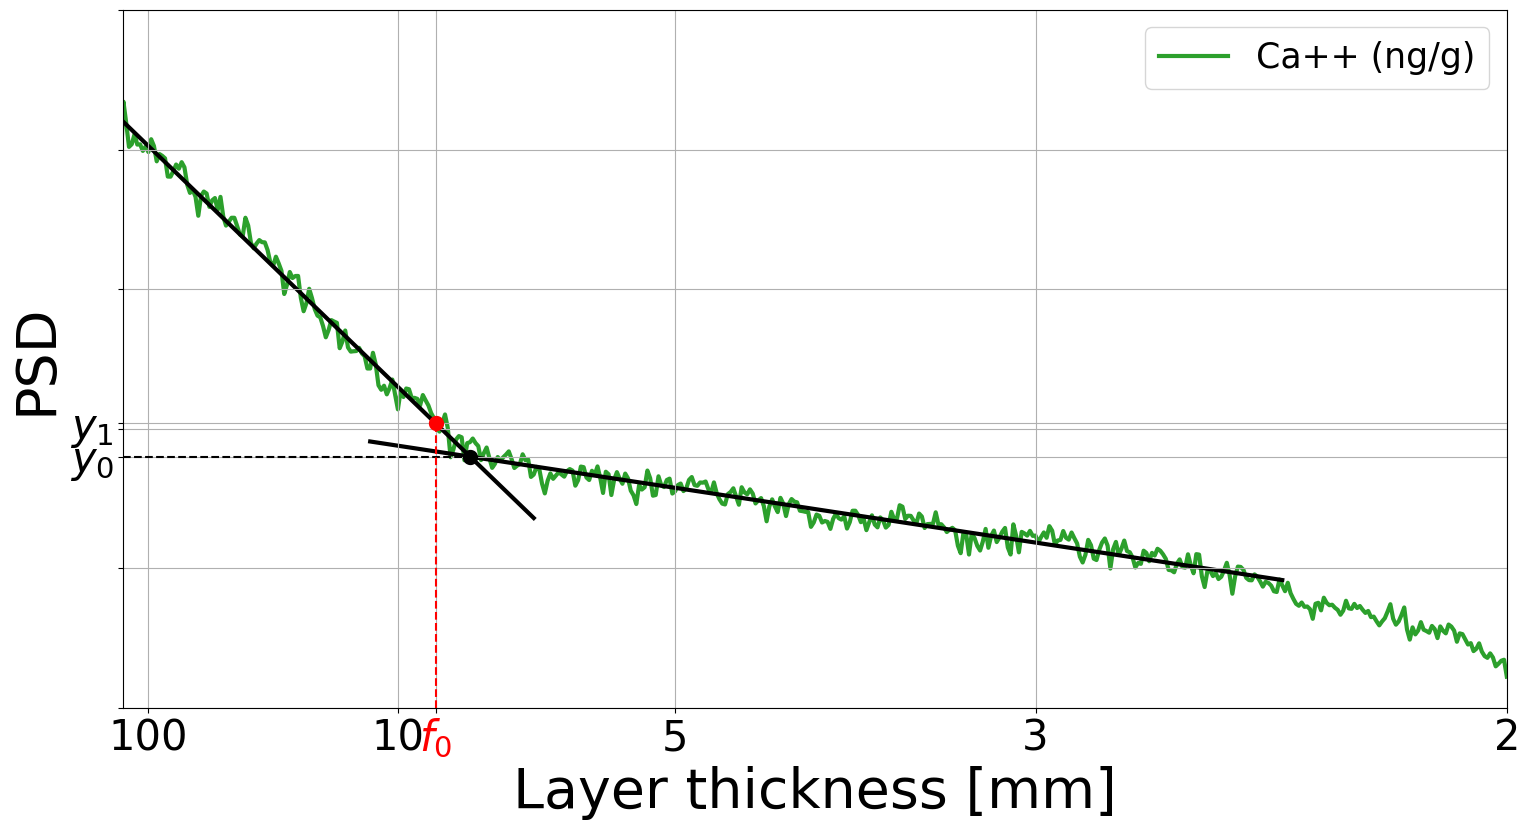

In [15]:
# Plot PSD of Ca2+
fs = 1 # sampling frequency in [1/mm]
for key in CFA_interp_slic.keys()[3:4]:
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.ticklabel_format(axis='y', style='sci', useOffset=False)    
    ax.grid()
    f, Pxx = welch(CFA_interp_slic[key],fs,nperseg = 1000)
    a1,b1=np.polyfit(f[:120],np.log(Pxx[:120]),1)
    a2,b2=np.polyfit(f[125:420],np.log(Pxx[125:420]),1)
    intersection_f = (b1-b2)/(a2-a1)
    intersection_y = a1*intersection_f+b1
    ax.semilogy(f, Pxx,label=key,zorder=0,lw=3,color="tab:green")
    ax.plot(f[:150],np.exp(a1*f[:150]+b1),color="black",zorder=0,lw=3)
    ax.plot(f[90:420],np.exp(a2*f[90:420]+b2),color="black",zorder=0,lw=3)
    ax.scatter(intersection_f,np.exp(intersection_y),c="black",alpha=1,marker="o",zorder=1,linewidths=5)
    ax.axhline(y=np.exp(intersection_y), xmin=0, xmax=intersection_f/0.5,ls="--",c="black")
    y2 = 3*np.exp(intersection_y)
    f_final = (np.log(y2)-b1)/a1
    ax.scatter(f_final,y2,c="red",alpha=1,marker="o",linewidths=5)
    ax.axvline(x=f_final, ymax=0.4,ls="--",c="red")
    f_err_mm = abs(1/f_final-1/intersection_f)
    print("sampling resolution ({}): ".format(key),round(1/f_final,2)," + ",round(f_err_mm,2),"mm")
    print("\t fit signal interval: ",round(f[0],2),"< f < ", round(f[120],2),"1/mm")
    print("\t fit signal interval: ",round(f[125],2),"< f < ", round(f[420],2),"1/mm")
    resolution_mm[key] = round(1/f_final,2)
    ax.set_xlim(0.001,0.5)
    ax.set_xticks([f_final,1/100,0.1,0.2,0.33,0.5])
    ax.set_xticklabels([r"$f_{0}$",100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()[1:-1]
    yticks = np.concatenate((yticks,np.array([np.exp(intersection_y),y2])))
    ax.set_yticks(yticks)
    y_labels = np.ones(len(yticks[:-2]),dtype="U8")
    y_labels[:] = ""
    ylabels = np.concatenate((y_labels,np.array(["$y_0$","$y_1$"])))
    y_color = np.ones(len(yticks[:-2]),dtype="U8")
    y_color[:] = "black"
    y_color = np.concatenate((y_color,np.array(["black","black"])))
    ax.set_yticklabels(ylabels)
    x_color = np.ones(len(xticks[:-1]),dtype="U8")
    x_color[:] = "black"
    x_color = np.concatenate((np.array(["red"]),x_color))
    [t.set_color(i) for (i,t) in zip(y_color,ax.yaxis.get_ticklabels())]
    [t.set_color(i) for (i,t) in zip(x_color,ax.xaxis.get_ticklabels())]
    ax.set_xlabel('Layer thickness [mm]')
    ax.set_ylabel('PSD')
    #ax.set_title("PSD of {}".format(key))
    ax.legend()
    fig.tight_layout()
    fig.savefig("Plots/17_PSD_Ca++.png",dpi=100)
    fig.show()

sampling resolution (Dust (#/mL) [SD>1.0]):  8.69  +  1.37 mm
	 fit signal interval:  0.0 < f <  0.14 1/mm
	 fit signal interval:  0.2 < f <  0.33 1/mm


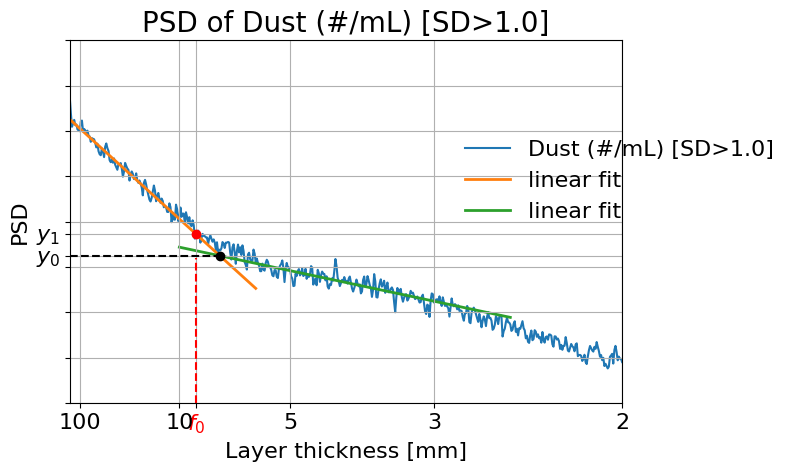

In [18]:
# Plot PSD of Dust
fs = 1 # sampling frequency in [1/mm]
for key in CFA_interp_slic.keys()[4:5]:
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.ticklabel_format(axis='y', style='sci', useOffset=False)    
    ax.grid(axis="both")
    f, Pxx = welch(CFA_interp_slic[key],fs,nperseg = 1000)
    a1,b1=np.polyfit(f[:95],np.log(Pxx[:95]),1)
    a2,b2=np.polyfit(f[200:334],np.log(Pxx[200:334]),1)
    intersection_f = (b1-b2)/(a2-a1)
    intersection_y = a1*intersection_f+b1
    ax.semilogy(f, Pxx,label=key,zorder=0)
    ax.plot(f[:170],np.exp(a1*f[:170]+b1),label="linear fit",zorder=0,lw=2)
    ax.plot(f[100:400],np.exp(a2*f[100:400]+b2),label="linear fit",zorder=0,lw=2)
    ax.scatter(intersection_f,np.exp(intersection_y),c="black",alpha=1,marker="o",zorder=1)
    ax.axhline(y=np.exp(intersection_y), xmin=0, xmax=intersection_f/0.5,ls="--",c="black")
    y2 = 3*np.exp(intersection_y)
    f_final = (np.log(y2)-b1)/a1
    ax.scatter(f_final,y2,c="red",alpha=1,marker="o")
    ax.axvline(x=f_final, ymax=0.4,ls="--",c="red")
    f_err_mm = abs(1/f_final-1/intersection_f)
    print("sampling resolution ({}): ".format(key),round(1/f_final,2)," + ",round(f_err_mm,2),"mm")
    print("\t fit signal interval: ",round(f[0],2),"< f < ", round(f[135],2),"1/mm")
    print("\t fit signal interval: ",round(f[200],2),"< f < ", round(f[334],2),"1/mm")
    resolution_mm[key] = round(1/f_final,2)
    ax.set_xlim(0.001,0.5)
    ax.set_xticks([f_final,1/100,0.1,0.2,0.33,0.5])
    ax.set_xticklabels([r"$f_{0}$",100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()[1:-1]
    yticks = np.concatenate((yticks,np.array([np.exp(intersection_y),y2])))
    ax.set_yticks(yticks)
    y_labels = np.ones(len(yticks[:-2]),dtype="U8")
    y_labels[:] = ""
    ylabels = np.concatenate((y_labels,np.array(["$y_0$","$y_1$"])))
    y_color = np.ones(len(yticks[:-2]),dtype="U8")
    y_color[:] = "black"
    y_color = np.concatenate((y_color,np.array(["black","black"])))
    ax.set_yticklabels(ylabels)
    x_color = np.ones(len(xticks[:-1]),dtype="U8")
    x_color[:] = "black"
    x_color = np.concatenate((np.array(["red"]),x_color))
    [t.set_color(i) for (i,t) in zip(y_color,ax.yaxis.get_ticklabels())]
    [t.set_color(i) for (i,t) in zip(x_color,ax.xaxis.get_ticklabels())]
    ax.set_xlabel('Layer thickness [mm]')
    ax.set_ylabel('PSD')
    ax.set_title("PSD of {}".format(key))
    ax.legend(bbox_to_anchor= (0.7, 0.75), ncol=1,
                borderaxespad=0, frameon=False)
    fig.tight_layout()
    fig.show()

sampling resolution (NH4+ (ng/g)):  11.21  +  1.05 mm
	 fit signal interval:  0.0 < f <  0.14 1/mm
	 fit signal interval:  0.2 < f <  0.33 1/mm


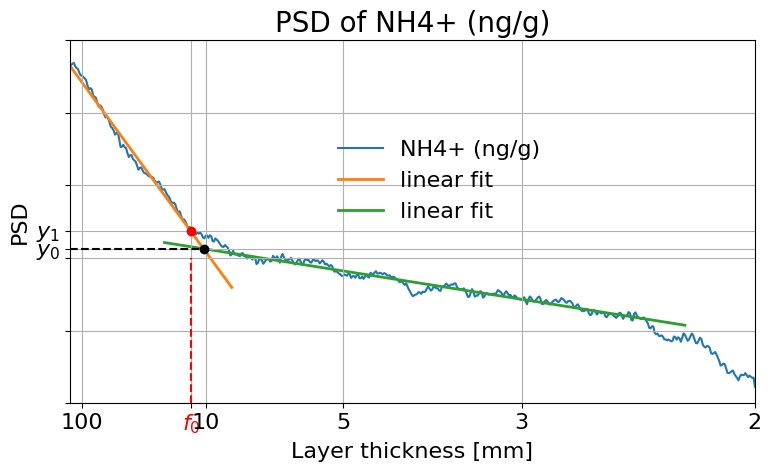

In [19]:
# Plot PSD of NH4+
fs = 1 # sampling frequency in [1/mm]
for key in CFA_interp_slic.keys()[5:6]:
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.ticklabel_format(axis='y', style='sci', useOffset=False)    
    ax.grid(axis="both")
    f, Pxx = welch(CFA_interp_slic[key],fs,nperseg = 1000)
    a1,b1=np.polyfit(f[:90],np.log(Pxx[:90]),1)
    a2,b2=np.polyfit(f[120:425],np.log(Pxx[120:425]),1)
    intersection_f = (b1-b2)/(a2-a1)
    intersection_y = a1*intersection_f+b1
    ax.semilogy(f, Pxx,label=key,zorder=0)
    ax.plot(f[:120],np.exp(a1*f[:120]+b1),label="linear fit",zorder=0,lw=2)
    ax.plot(f[70:450],np.exp(a2*f[70:450]+b2),label="linear fit",zorder=0,lw=2)
    ax.scatter(intersection_f,np.exp(intersection_y),c="black",alpha=1,marker="o",zorder=1)
    ax.axhline(y=np.exp(intersection_y), xmin=0, xmax=intersection_f/0.5,ls="--",c="black")
    y2 = 3*np.exp(intersection_y)
    f_final = (np.log(y2)-b1)/a1
    ax.scatter(f_final,y2,c="red",alpha=1,marker="o")
    ax.axvline(x=f_final, ymax=0.4,ls="--",c="red")
    f_err_mm = abs(1/f_final-1/intersection_f)
    print("sampling resolution ({}): ".format(key),round(1/f_final,2)," + ",round(f_err_mm,2),"mm")
    print("\t fit signal interval: ",round(f[0],2),"< f < ", round(f[135],2),"1/mm")
    print("\t fit signal interval: ",round(f[200],2),"< f < ", round(f[334],2),"1/mm")
    resolution_mm[key] = round(1/f_final,2)
    ax.set_xlim(0.001,0.5)
    ax.set_xticks([f_final,1/100,0.1,0.2,0.33,0.5])
    ax.set_xticklabels([r"$f_{0}$",100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()[1:-1]
    yticks = np.concatenate((yticks,np.array([np.exp(intersection_y),y2])))
    ax.set_yticks(yticks)
    y_labels = np.ones(len(yticks[:-2]),dtype="U8")
    y_labels[:] = ""
    ylabels = np.concatenate((y_labels,np.array(["$y_0$","$y_1$"])))
    y_color = np.ones(len(yticks[:-2]),dtype="U8")
    y_color[:] = "black"
    y_color = np.concatenate((y_color,np.array(["black","black"])))
    ax.set_yticklabels(ylabels)
    x_color = np.ones(len(xticks[:-1]),dtype="U8")
    x_color[:] = "black"
    x_color = np.concatenate((np.array(["red"]),x_color))
    [t.set_color(i) for (i,t) in zip(y_color,ax.yaxis.get_ticklabels())]
    [t.set_color(i) for (i,t) in zip(x_color,ax.xaxis.get_ticklabels())]
    ax.set_xlabel('Layer thickness [mm]')
    ax.set_ylabel('PSD')
    ax.set_title("PSD of {}".format(key))
    ax.legend(bbox_to_anchor= (0.7, 0.75), ncol=1,
                borderaxespad=0, frameon=False)
    fig.tight_layout()
    fig.show()

sampling resolution (NO3- (ng/g)):  9.09  +  0.92 mm
	 fit signal interval:  0.0 < f <  0.14 1/mm
	 fit signal interval:  0.2 < f <  0.33 1/mm


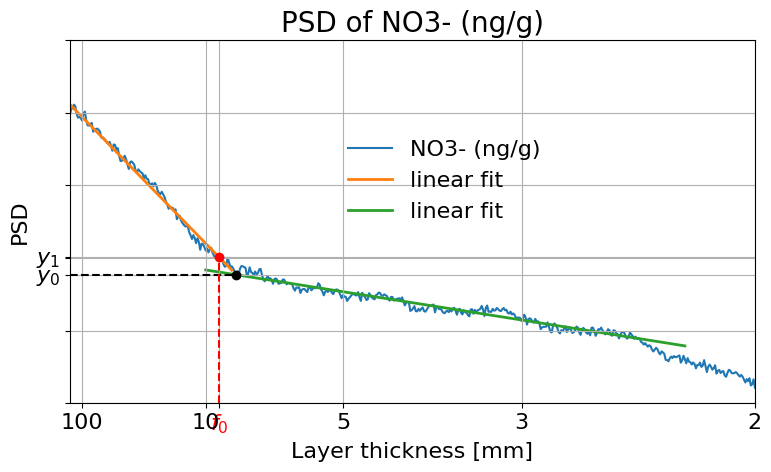

In [20]:
# Plot PSD of NO3-
fs = 1 # sampling frequency in [1/mm]
for key in CFA_interp_slic.keys()[6:7]:
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.ticklabel_format(axis='y', style='sci', useOffset=False)    
    ax.grid(axis="both")
    f, Pxx = welch(CFA_interp_slic[key],fs,nperseg = 1000)
    a1,b1=np.polyfit(f[:97],np.log(Pxx[:97]),1)
    a2,b2=np.polyfit(f[125:420],np.log(Pxx[125:420]),1)
    intersection_f = (b1-b2)/(a2-a1)
    intersection_y = a1*intersection_f+b1
    ax.semilogy(f, Pxx,label=key,zorder=0)
    ax.plot(f[:120],np.exp(a1*f[:120]+b1),label="linear fit",zorder=0,lw=2)
    ax.plot(f[100:450],np.exp(a2*f[100:450]+b2),label="linear fit",zorder=0,lw=2)
    ax.scatter(intersection_f,np.exp(intersection_y),c="black",alpha=1,marker="o",zorder=1)
    ax.axhline(y=np.exp(intersection_y), xmin=0, xmax=intersection_f/0.5,ls="--",c="black")
    y2 = 3*np.exp(intersection_y)
    f_final = (np.log(y2)-b1)/a1
    ax.scatter(f_final,y2,c="red",alpha=1,marker="o")
    ax.axvline(x=f_final, ymax=0.4,ls="--",c="red")
    f_err_mm = abs(1/f_final-1/intersection_f)
    print("sampling resolution ({}): ".format(key),round(1/f_final,2)," + ",round(f_err_mm,2),"mm")
    print("\t fit signal interval: ",round(f[0],2),"< f < ", round(f[135],2),"1/mm")
    print("\t fit signal interval: ",round(f[200],2),"< f < ", round(f[334],2),"1/mm")
    resolution_mm[key] = round(1/f_final,2)
    ax.set_xlim(0.001,0.5)
    ax.set_xticks([f_final,1/100,0.1,0.2,0.33,0.5])
    ax.set_xticklabels([r"$f_{0}$",100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()[1:-1]
    yticks = np.concatenate((yticks,np.array([np.exp(intersection_y),y2])))
    ax.set_yticks(yticks)
    y_labels = np.ones(len(yticks[:-2]),dtype="U8")
    y_labels[:] = ""
    ylabels = np.concatenate((y_labels,np.array(["$y_0$","$y_1$"])))
    y_color = np.ones(len(yticks[:-2]),dtype="U8")
    y_color[:] = "black"
    y_color = np.concatenate((y_color,np.array(["black","black"])))
    ax.set_yticklabels(ylabels)
    x_color = np.ones(len(xticks[:-1]),dtype="U8")
    x_color[:] = "black"
    x_color = np.concatenate((np.array(["red"]),x_color))
    [t.set_color(i) for (i,t) in zip(y_color,ax.yaxis.get_ticklabels())]
    [t.set_color(i) for (i,t) in zip(x_color,ax.xaxis.get_ticklabels())]
    ax.set_xlabel('Layer thickness [mm]')
    ax.set_ylabel('PSD')
    ax.set_title("PSD of {}".format(key))
    ax.legend(bbox_to_anchor= (0.7, 0.75), ncol=1,
                borderaxespad=0, frameon=False)
    fig.tight_layout()
    fig.show()

### 4. Perform downsampling to desired resolution

In [21]:
resolution_mm

{'Cond (mikroS/cm)': 7.31,
 'Na+ (ng/g)': 12.12,
 'Ca++ (ng/g)': 8.8,
 'Dust (#/mL) [SD>1.0]': 8.69,
 'NH4+ (ng/g)': 11.21,
 'NO3- (ng/g)': 9.09}

In [22]:
#CFA_ds = pd.DataFrame(columns = CFA_interp_slic.keys())
df_mean = {}
depth_0 = CFA_interp_slic["Depth top (m)"].iloc[0]
for key in CFA_interp_slic.keys()[1:5]:
    print(key)
    res = resolution_mm[key]/1000 #resolution in m
    n = int(len(CFA_interp_slic["Depth top (m)"])/(res*1000))
    depth = np.array([])
    mean = np.array([])
    for i in range(n):
        depth_min = depth_0 + res*i
        depth_max = depth_0 + res*(i+1)
        depth = np.concatenate((depth,np.array([depth_min+res/2])))
        CFA_interp_slic_int = CFA_interp_slic[CFA_interp_slic["Depth top (m)"]>=depth_min]
        CFA_interp_slic_int = CFA_interp_slic_int[CFA_interp_slic_int["Depth top (m)"]<depth_max]
        mean = np.concatenate((mean,np.array([np.mean(CFA_interp_slic_int[key])])))
    df_mean[key] = pd.DataFrame(data=[depth,mean]).T
    df_mean[key].columns = [CFA_interp_slic.keys()[0],key] 

Cond (mikroS/cm)
Na+ (ng/g)
Ca++ (ng/g)
Dust (#/mL) [SD>1.0]


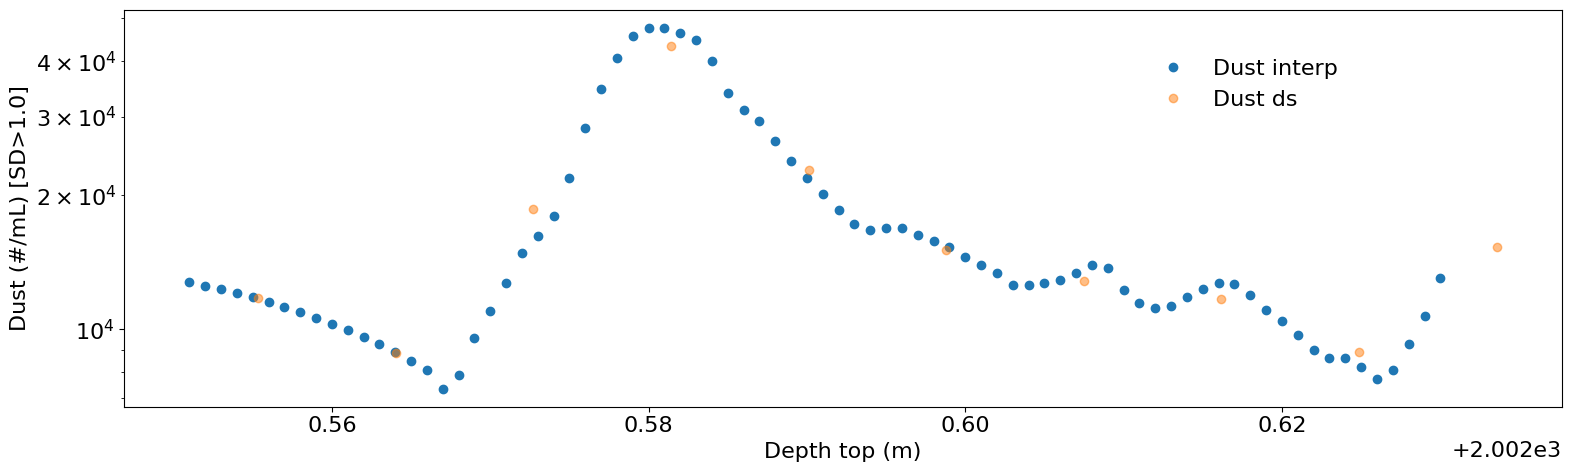

In [23]:
# Plot interpolated and down sampled data
fig, ax = plt.subplots(figsize=(16, 5))
ax.semilogy(CFA_interp_slic["Depth top (m)"].iloc[:80], CFA_interp_slic["Dust (#/mL) [SD>1.0]"].iloc[:80], 'o',label="Dust interp",alpha=1)
ax.semilogy(df_mean["Dust (#/mL) [SD>1.0]"]["Depth top (m)"].iloc[:10], df_mean["Dust (#/mL) [SD>1.0]"]["Dust (#/mL) [SD>1.0]"].iloc[:10], 'o',label="Dust ds",alpha=0.5)
ax.set_xlabel('Depth top (m)')
ax.set_ylabel('Dust (#/mL) [SD>1.0]')
ax.legend(loc="best", bbox_to_anchor= (0.85, 0.9), ncol=1,
            borderaxespad=0, frameon=False)

plt.tight_layout()
plt.show()

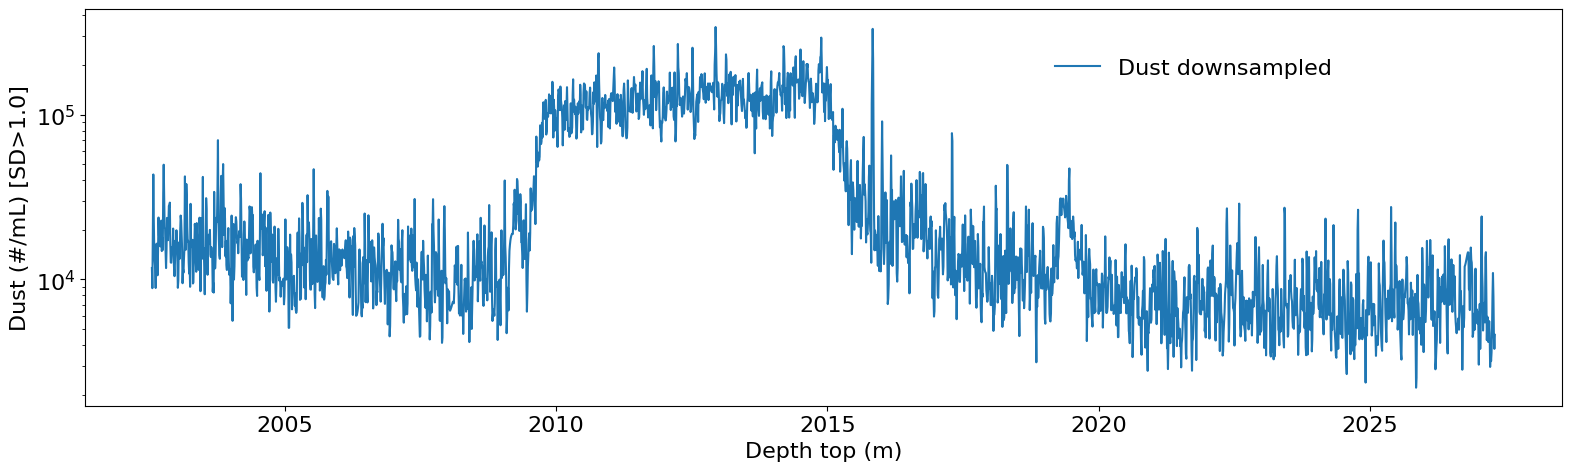

In [24]:
# Plot only down sampled data
fig, ax = plt.subplots(figsize=(16, 5))
ax.semilogy(df_mean["Dust (#/mL) [SD>1.0]"]["Depth top (m)"], df_mean["Dust (#/mL) [SD>1.0]"]["Dust (#/mL) [SD>1.0]"], '-',label="Dust downsampled")
ax.set_xlabel('Depth top (m)')
ax.set_ylabel('Dust (#/mL) [SD>1.0]')
ax.legend(loc="best", bbox_to_anchor= (0.85, 0.9), ncol=1,
            borderaxespad=0, frameon=False)

plt.tight_layout()
plt.show()

### 5. Save down sampled CFA data as csv file

In [25]:
#for key in df_mean.keys():
#    df_mean[key].to_csv("/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/CFA_downsampled/ds_{}.csv".format(key[:4]),index=False)

### 6. Check PSD of down sampled CFA

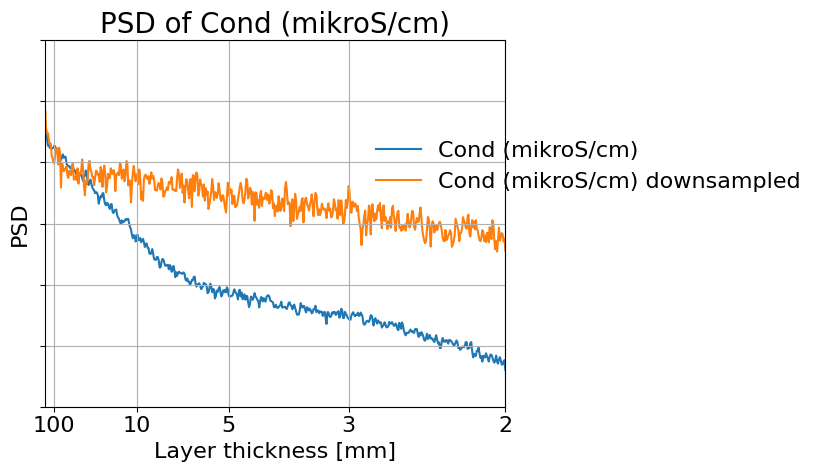

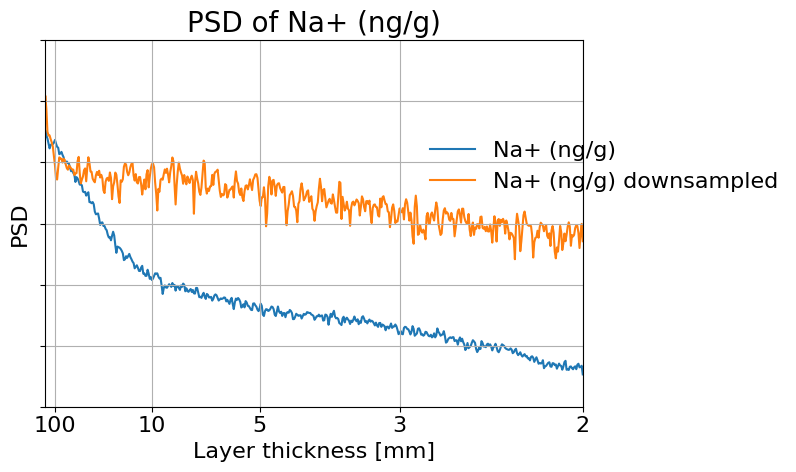

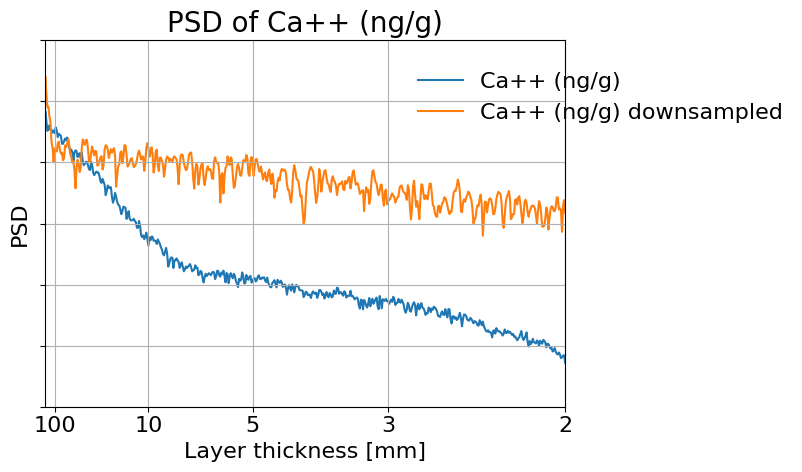

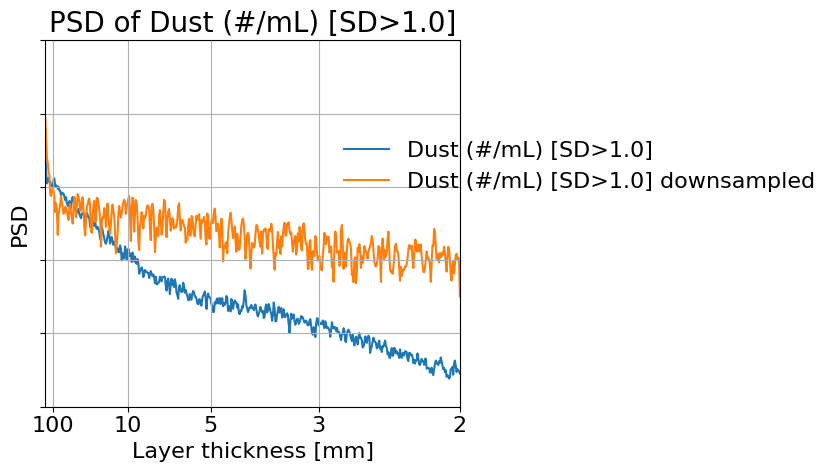

In [26]:
# Plot PSD of Conductivity
fs = 1 # sampling frequency in [1/mm]
for key in CFA_interp_slic.keys()[1:5]:
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.ticklabel_format(axis='y', style='sci', useOffset=False)    
    ax.grid()
    f, Pxx = welch(CFA_interp_slic[key],fs,nperseg = 1000)
    ax.semilogy(f, Pxx,label=key,zorder=0)
    f, Pxx = welch(df_mean[key][key],fs,nperseg = 1000)
    ax.semilogy(f, Pxx,label=key+" downsampled",zorder=0)
    ax.set_xlim(0.001,0.5)
    ax.set_xticks([1/100,0.1,0.2,0.33,0.5])
    ax.set_xticklabels([100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
    ax.set_yticklabels("")
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()[1:-1]
    ax.set_yticks(yticks)
    ax.set_xlabel('Layer thickness [mm]')
    ax.set_ylabel('PSD')
    ax.set_title("PSD of {}".format(key))
    ax.legend(bbox_to_anchor= (0.7, 0.75), ncol=1,
                borderaxespad=0, frameon=False)
    fig.tight_layout()

    fig.show()

### 7. Bring xLASM data to same resolution

In [27]:
resolution_mm = {"10": 10}
df_sizes = {}
file_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/grain_sizes_depth/"

for key in resolution_mm.keys():
    print(key)
    path = file_path + "grain_data_interp_{}mm.csv".format(resolution_mm[key])
    df_sizes[key] = pd.read_csv(path)
df_sizes["10"].head()

10


,depth[m],equivalent_diameter[px],grain_size[px]
0,2002.5525,311.282395,2.572660e+06
1,2002.5535,306.918161,2.484274e+06
2,2002.5545,307.574230,2.486482e+06
3,2002.5555,315.558276,2.645217e+06
4,2002.5565,312.389430,2.606206e+06
